<div class="alert alert-block alert-info">

<h1 style="font-family:verdana;"> Description:</h1>

<ul>
<li><p style="font-family:verdana;">
.
</p></li>
    
<li><p style="font-family:verdana;">
The dataset we are going to use is the US retail sales dataset from Kaggle which contains about 336 rows and 7 features that can be downloaded <a href="https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series/data?select=us-retail-sales.csv">here</a>.
</p></li>

<li><p style="font-family:verdana;">
</p></li>  
</ul>

</div>

In [2]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip3 install pandas_gbq

In [4]:
from warnings import simplefilter

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.offsetbox import AnchoredText
import math
from statsmodels.tsa.deterministic import DeterministicProcess
from scipy.signal import periodogram
import statsmodels.api as sm

sns.set_style('whitegrid')
%matplotlib inline


simplefilter("ignore")  # ignore warnings to clean up output cells


## Step 0: Importamos librerias y el dataset

In [5]:
%%bigquery us_retail
SELECT *
FROM demoespecialidadgcp.demo_ts.us_retail;

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
!rm us_retail.csv

us_retail.to_csv('us_retail.csv')

In [7]:
#Dataset whit parsed dates
categories = ['Clothing', 'Appliances', 'FoodAndBeverage', 'Automobiles', 'GeneralMerchandise', 'BuildingMaterials']

retail_sales = pd.read_csv(
    "./us_retail.csv",
    usecols=['Month'] + categories,
    parse_dates=['Month'],
    index_col='Month',
).to_period('M').reindex(columns=categories)
#retail_sales = pd.concat({'Sales': retail_sales}, names=[None, 'categories'], axis=1)

In [8]:
# Carga los datos en BigQuery
from google.cloud import bigquery

project_id = 'demoespecialidadgcp'
client = bigquery.Client(project=project_id)

#tabla test
dataset_id = 'demo_ts'
table_id = 'prueba'
table_ref = client.dataset(dataset_id).table(table_id)
job_config = bigquery.LoadJobConfig()
job = client.load_table_from_dataframe(retail_sales, table_ref, job_config=job_config)
job.result()  # Espera a que se complete el trabajo

LoadJob<project=demoespecialidadgcp, location=US, id=df44e315-0029-48f6-be24-3ff9831a32ff>

In [9]:
# Previsualizamos el dataset
retail_sales.head(100)

,Clothing,Appliances,FoodAndBeverage,Automobiles,GeneralMerchandise,BuildingMaterials
Month,,,,,,
2017-10,20469,7168,60762,89438,56416,29672
2019-07,21742,7170,66428,100703,58759,33691
1997-12,21118,10754,37330,45800,45371,15247
1996-07,10202,5891,34426,50106,24073,16228
1998-11,13854,7427,34557,47787,34377,16167
...,...,...,...,...,...,...
2001-12,24534,12872,43058,56356,57406,17221
1992-01,6938,3657,29589,26788,14996,8964
2012-04,18601,7241,50842,66592,50602,25989


## Step 1: Analisis descriptivo

In [22]:
retail_sales.isnull().sum()

Clothing              0
Appliances            0
FoodAndBeverage       0
Automobiles           0
GeneralMerchandise    0
BuildingMaterials     0
dtype: int64

In [11]:
retail_sales.isna().sum()

Clothing              0
Appliances            0
FoodAndBeverage       0
Automobiles           0
GeneralMerchandise    0
BuildingMaterials     0
dtype: int64

In [23]:
# Dataset dimensions - (rows, columns)
print('US Retail: \nRows: {} Columns: {}'.format(retail_sales.shape[0], us_retail.shape[1]))

US Retail: 
Rows: 336 Columns: 7


In [24]:
# Features data-type
retail_sales.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 336 entries, 2017-10 to 2012-07
Freq: M
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Clothing            336 non-null    int64
 1   Appliances          336 non-null    int64
 2   FoodAndBeverage     336 non-null    int64
 3   Automobiles         336 non-null    int64
 4   GeneralMerchandise  336 non-null    int64
 5   BuildingMaterials   336 non-null    int64
dtypes: int64(6)
memory usage: 18.4 KB


In [18]:
# Resumen estadístico
retail_sales.FoodAndBeverage.describe().T

count      336.000000
mean     44668.348214
std      10444.196145
min      28126.000000
25%      35517.000000
50%      42932.500000
75%      52877.000000
max      70028.000000
Name: FoodAndBeverage, dtype: float64

## Step 2: Analisis exploratorio de datos

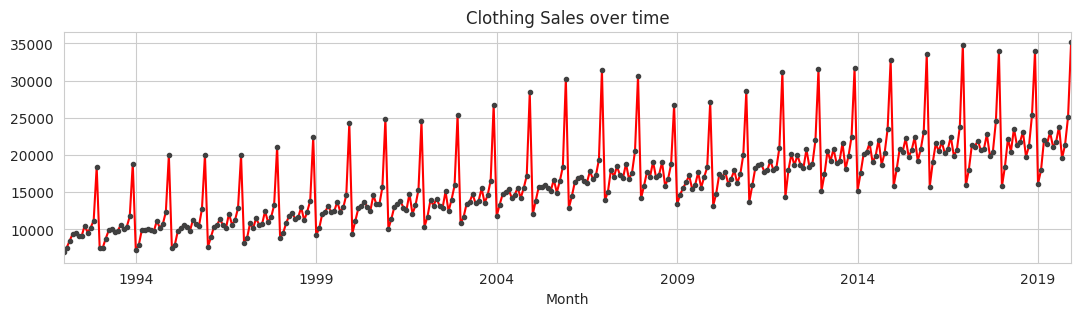

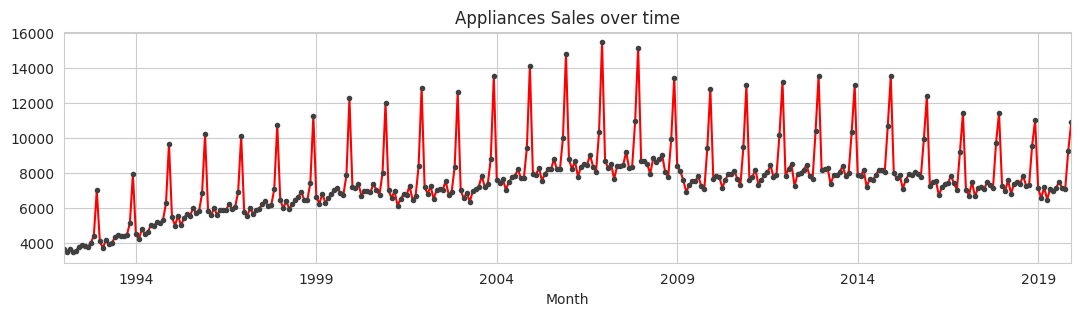

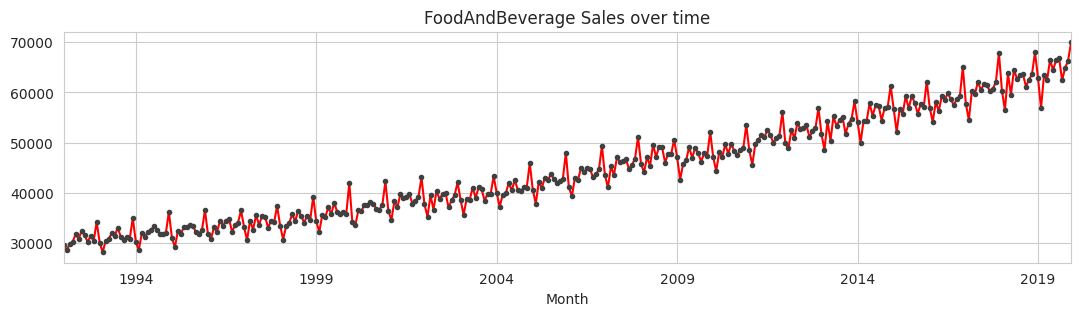

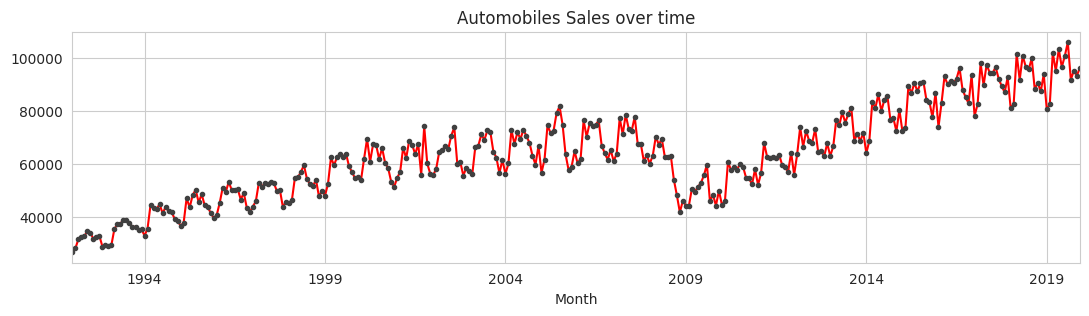

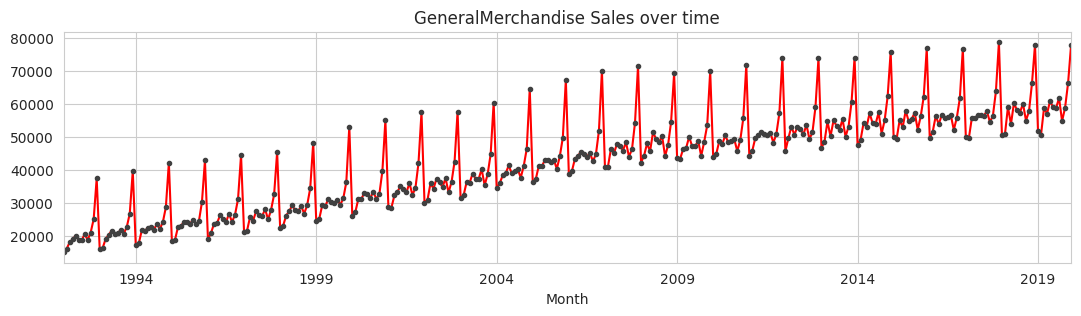

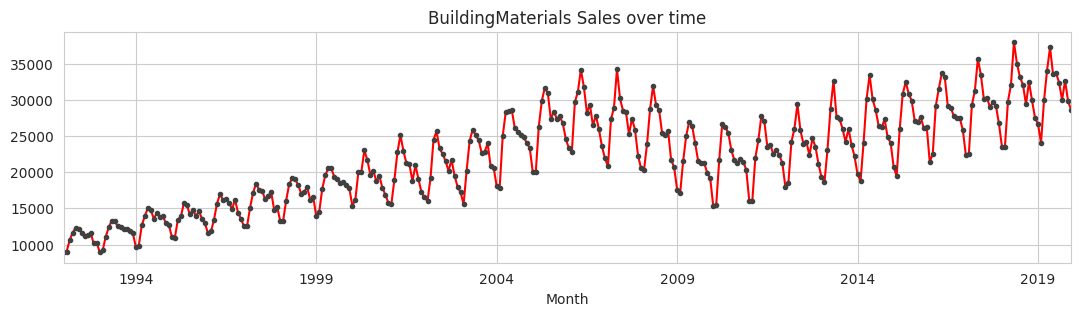

In [26]:
retail_sales = retail_sales.sort_values('Month')

for i in categories:
    
    retail_sales[i].plot(subplots=True, figsize=(13,3), style='.-', color= 'red',
                         markeredgecolor="0.25", markerfacecolor="0.25", legend=False,) # asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
    
    plt.title( i +' Sales over time')
    plt.show()

#### Time-Step features

In [39]:
step = retail_sales.copy()

step['Time'] = np.arange(len(step.index))

step.head()

,Clothing,Appliances,FoodAndBeverage,Automobiles,GeneralMerchandise,BuildingMaterials,Time
Month,,,,,,,
1992-01,6938,3657,29589,26788,14996,8964,0
1992-02,7524,3490,28570,28203,16015,9023,1
1992-03,8475,3669,29682,31684,17984,10608,2
1992-04,9401,3527,30228,32547,18872,11630,3
1992-05,9558,3571,31677,32883,20037,12327,4


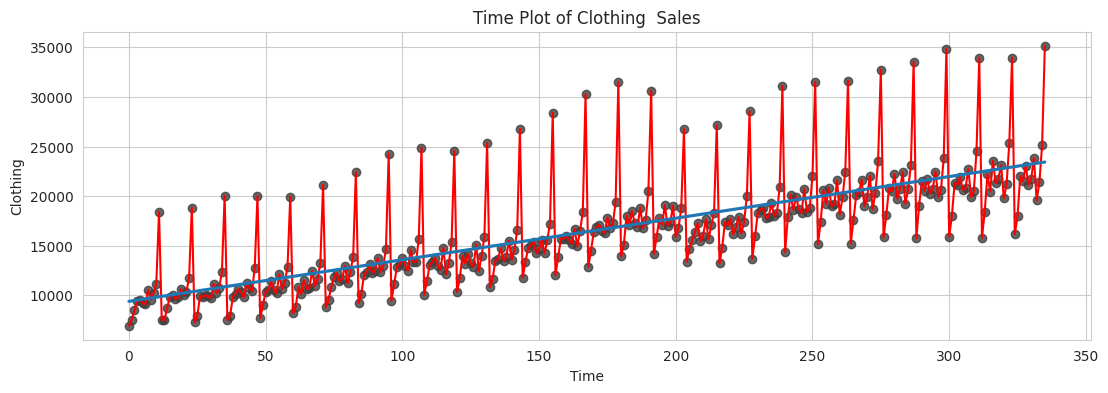

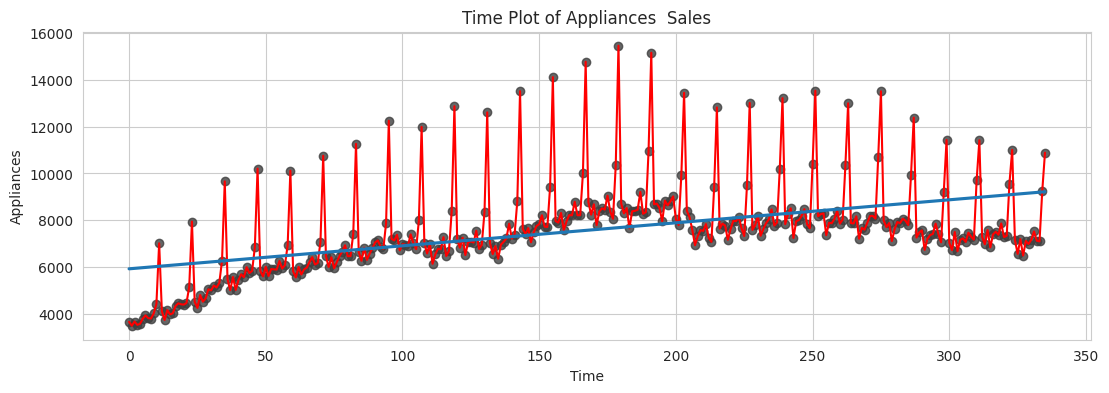

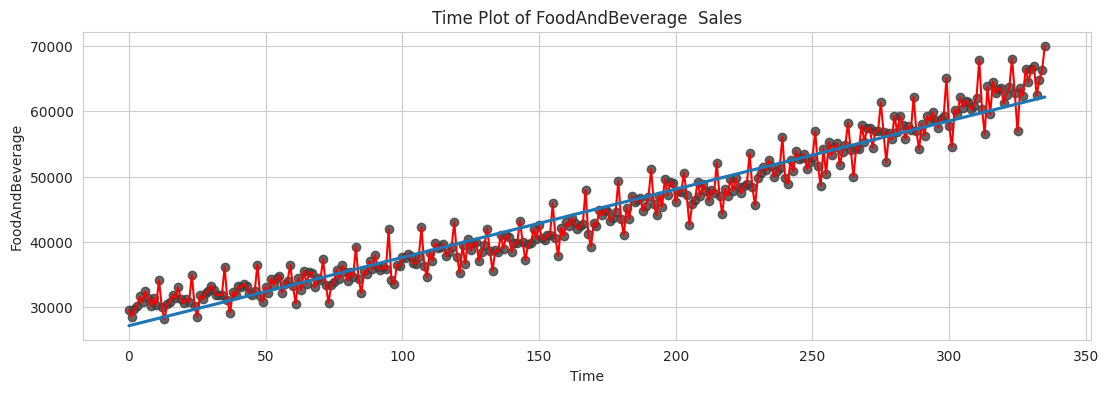

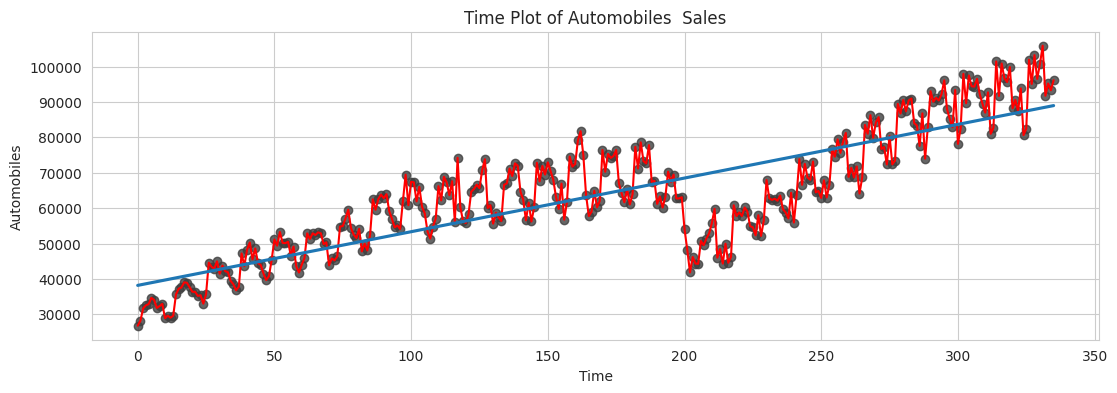

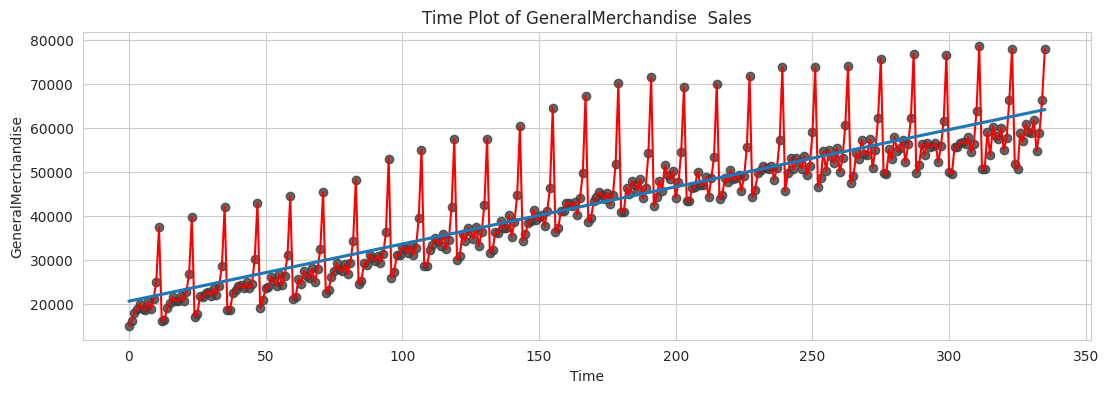

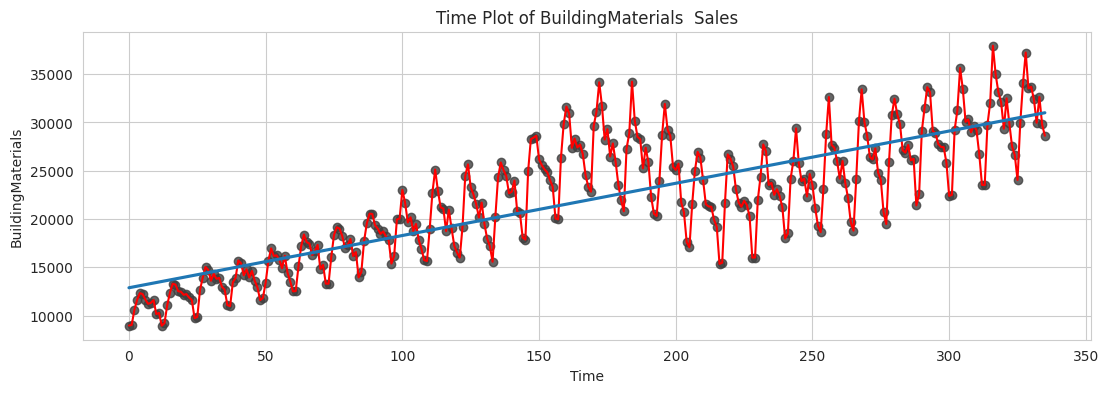

In [40]:
for i in categories:
    

    fig, ax = plt.subplots(figsize=(13,4))
    ax.plot('Time', i, data=step, color='red', )
    ax = sns.regplot(x='Time', y=i, data=step, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title('Time Plot of ' + i +' Sales');

Los time-step features permiten modelar la dependencia temporal. Una serie depende del tiempo si sus valores pueden predecirse a partir del momento en que se produjeron.

#### Lag features

Nuestros datos no muestran en todos los casos una estacionalidad regular: el pico tiende a producirse en torno al periodo anual, a veces mayor o menor, a veces antes o después. Modelizar estos ciclos con rasgos de desfase permitirá a nuestro pronosticador reaccionar dinámicamente a las condiciones cambiantes en lugar de estar constreñido a fechas y horas exactas como ocurre con los rasgos estacionales.

Para crear una lag feature, desplazamos las observaciones de la serie objetivo de modo que parezca que se han producido más tarde en el tiempo.

Veamos primero los gráficos de lag y autocorrelación:


In [13]:
#definimos funciones para graficar lag features

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):

    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

#### Graficamos lag features y autocorrelacion parcial

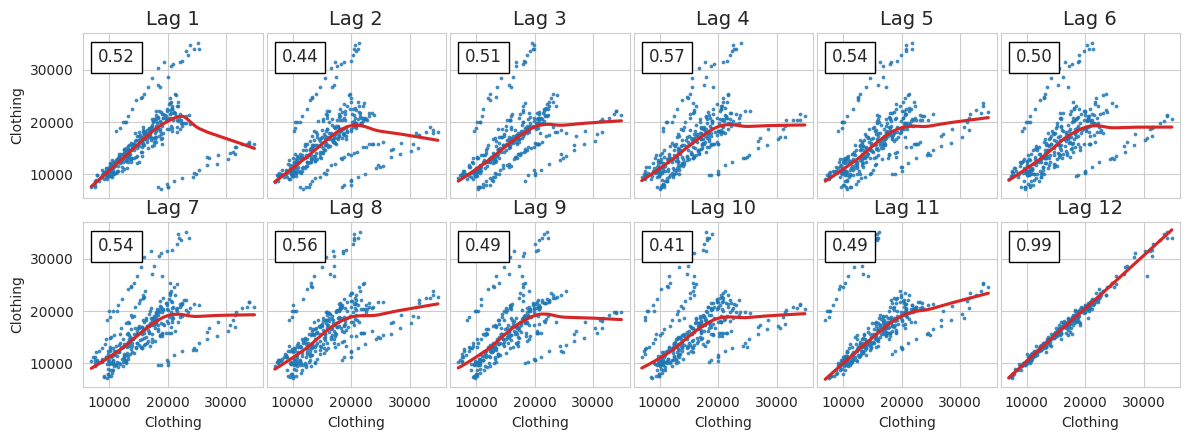

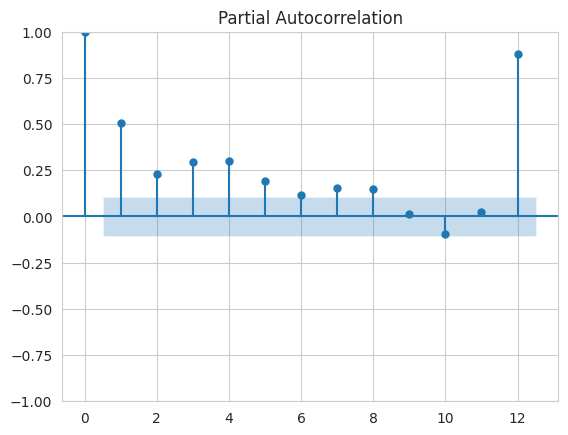

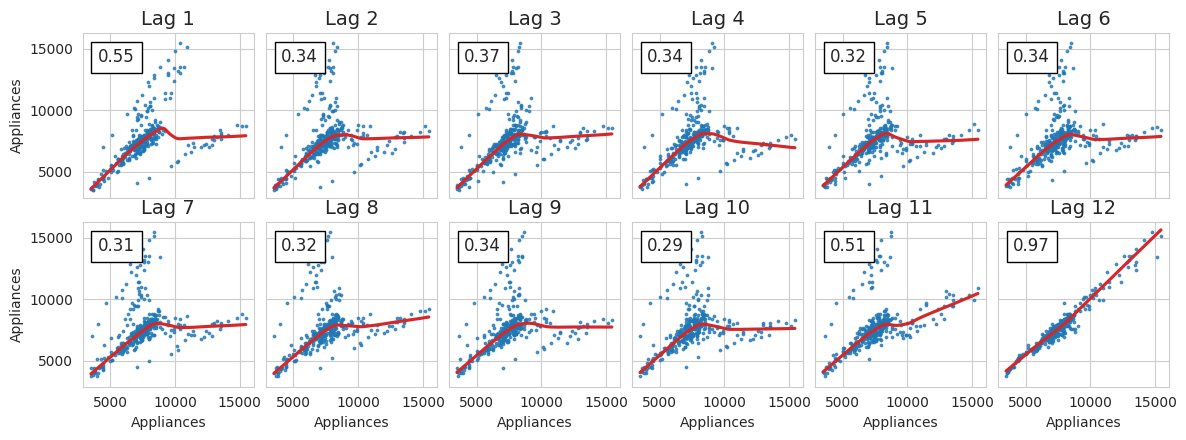

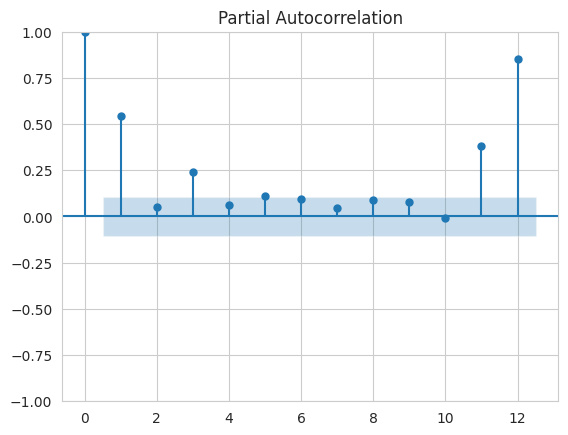

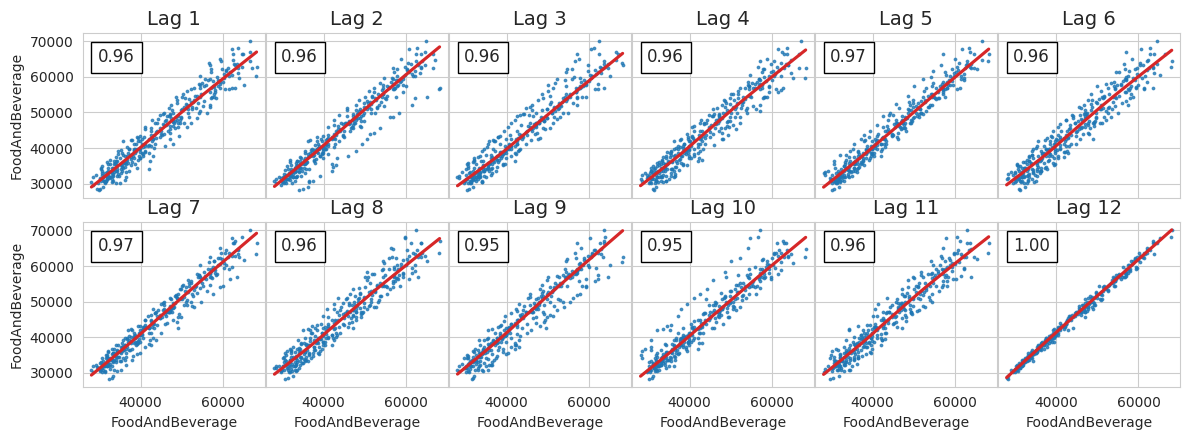

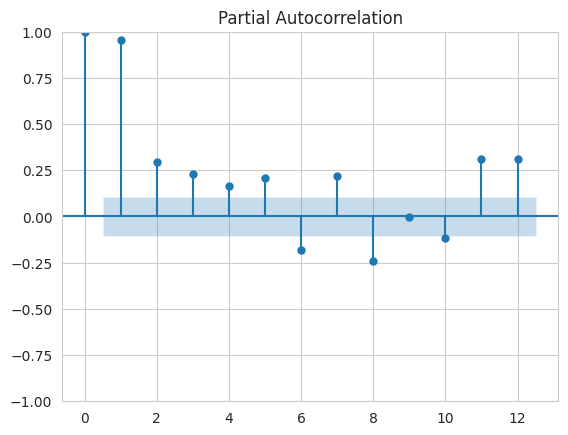

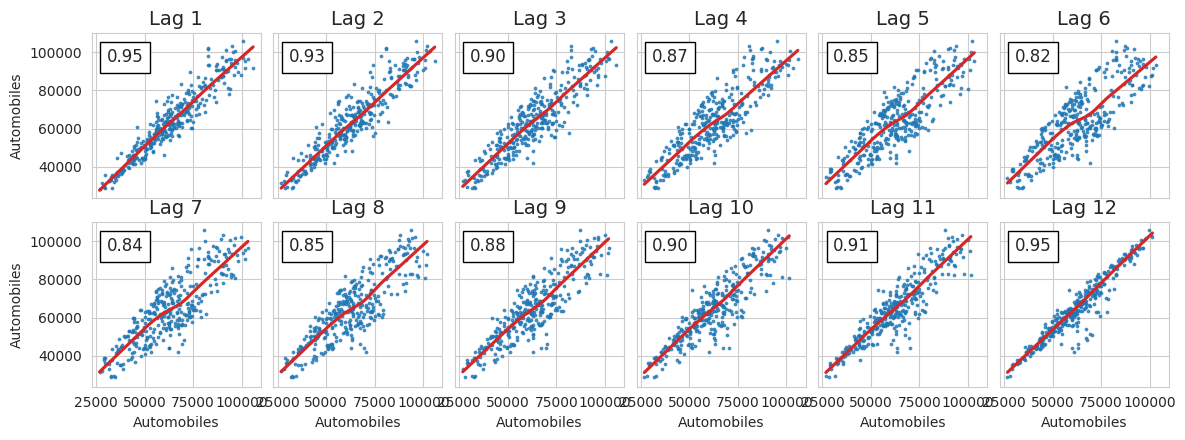

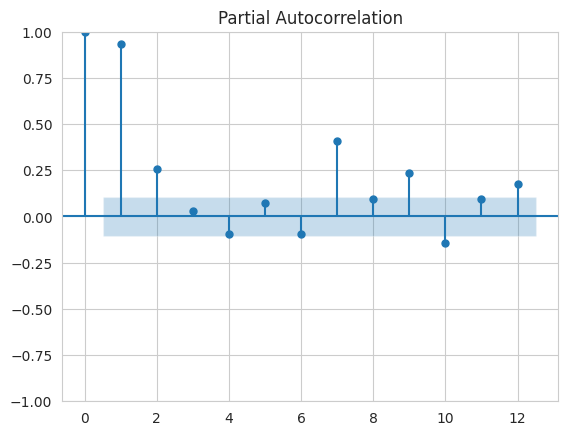

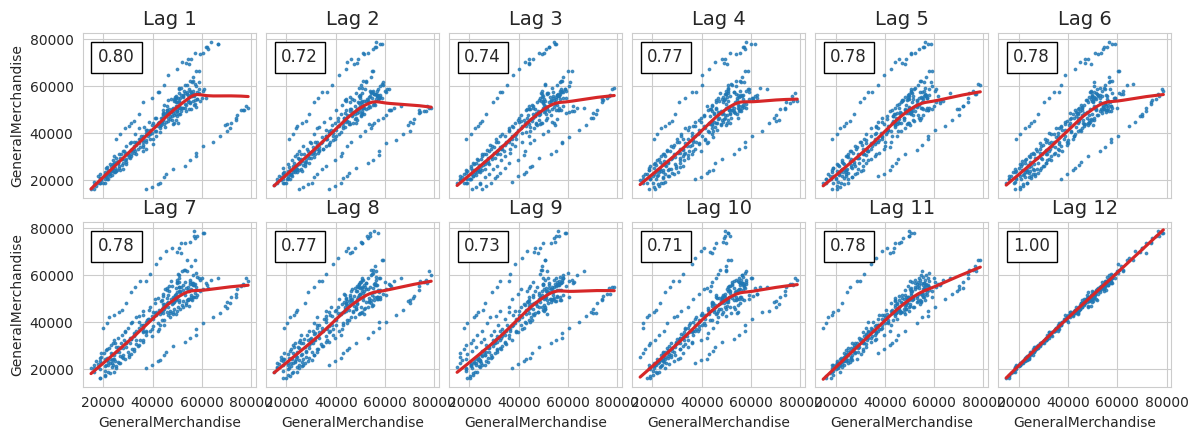

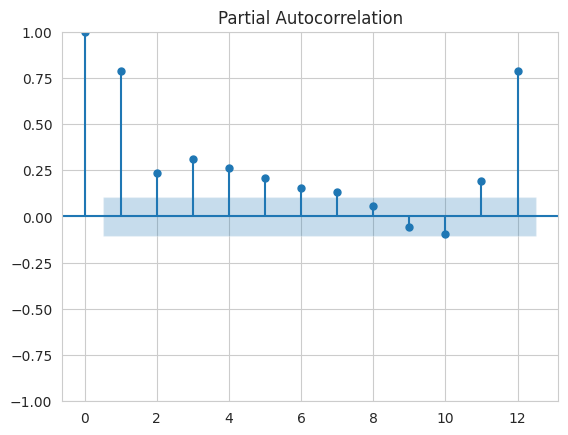

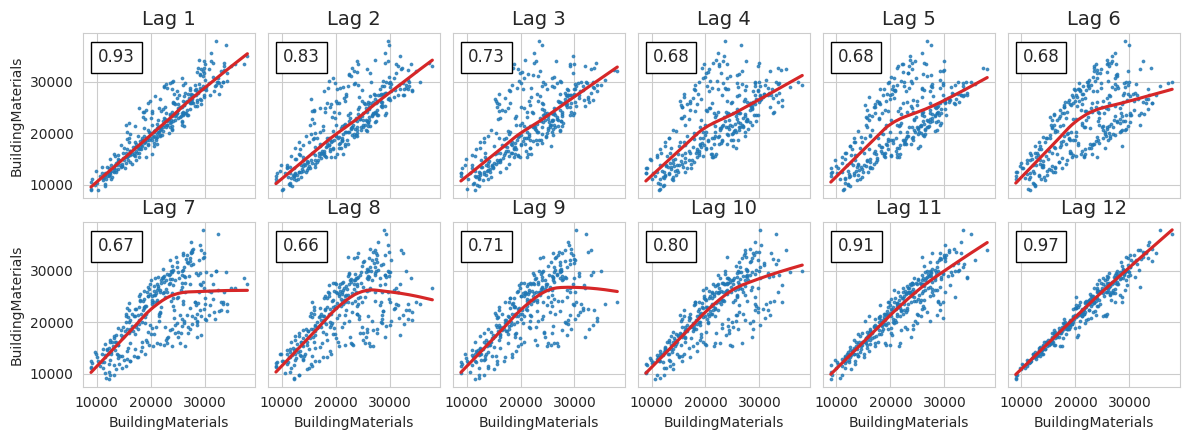

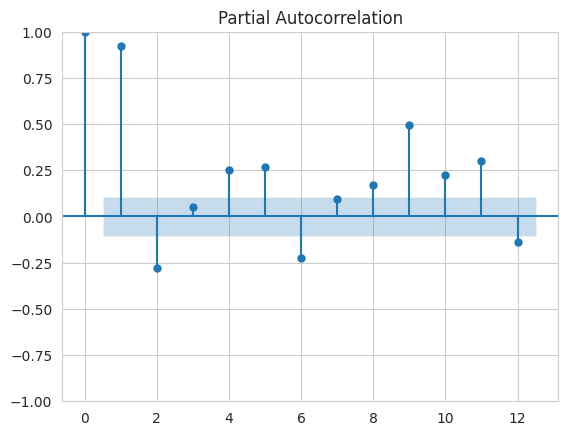

In [56]:
for i in categories:

    _ = plot_lags(retail_sales[i], lags=12, nrows=2)
    _ = plot_pacf(retail_sales[i], lags=12)

### Tendencias

Hagamos un gráfico de medias móviles (moving average) para ver qué tendencia tiene esta serie.

Para crear una media móvil, utilizamos primero el método 'rolling' para iniciar un cálculo por ventanas. A continuación, utilizamos el método de la media para calcular la media de la ventana.

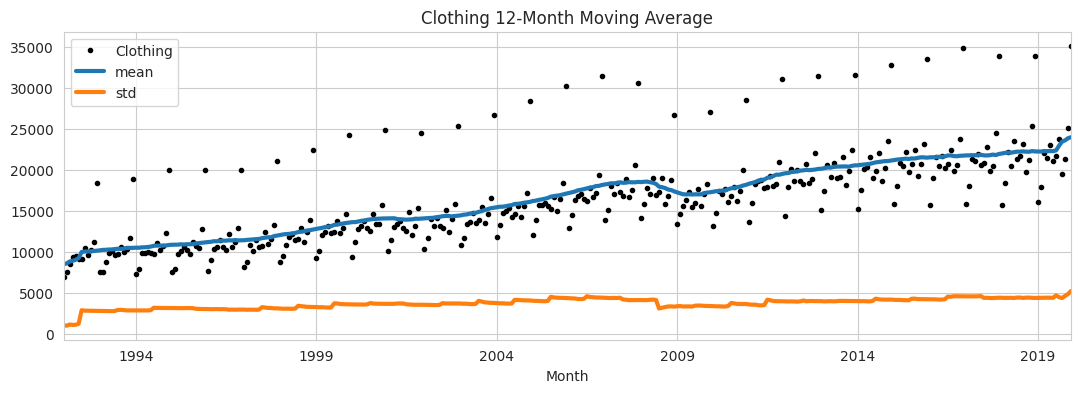

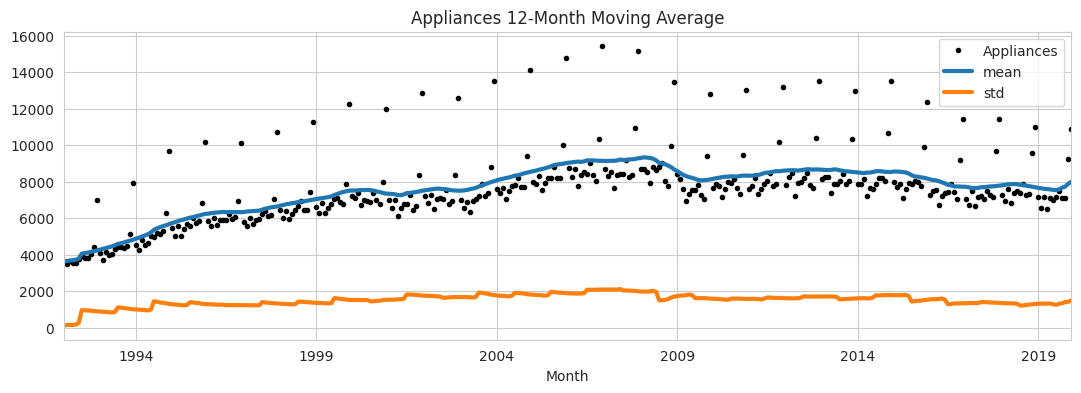

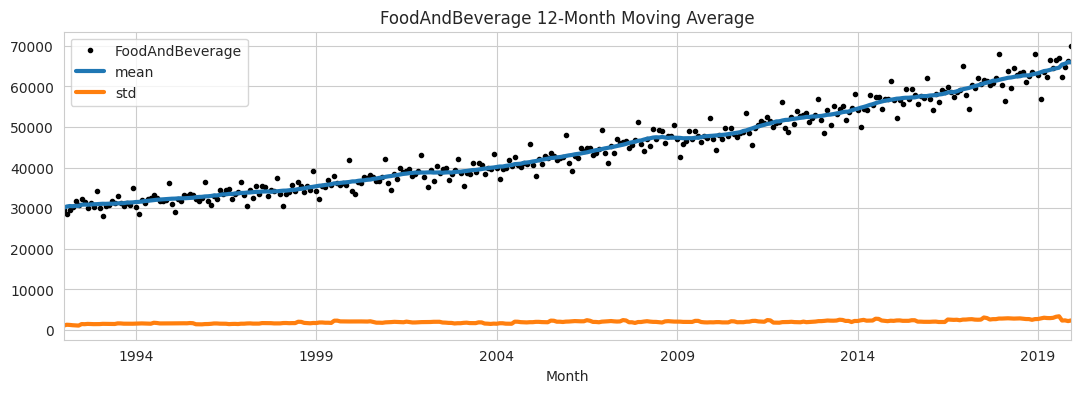

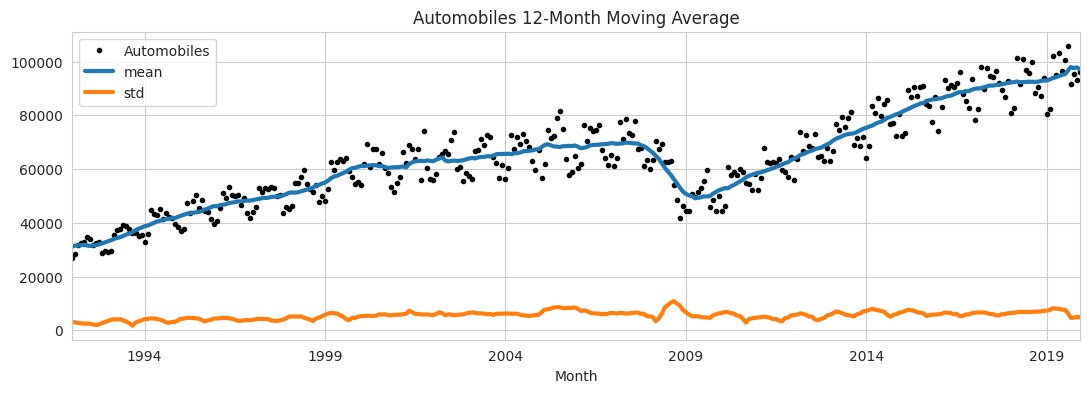

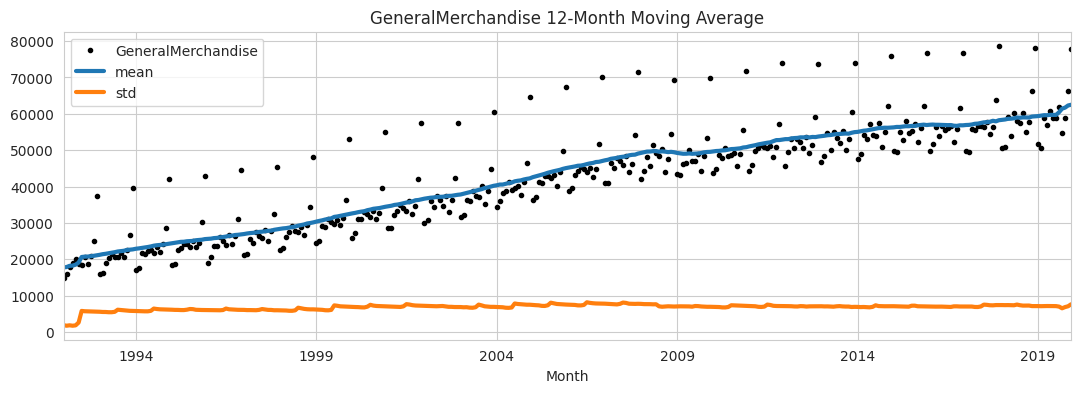

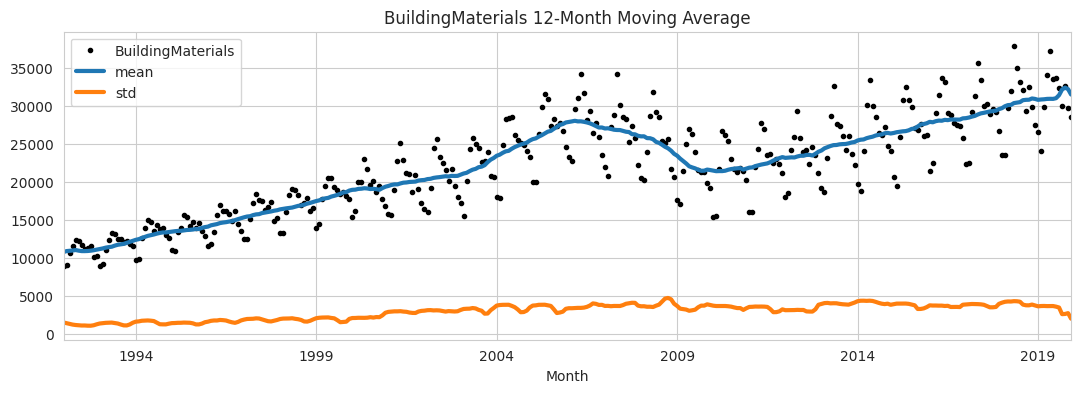

In [100]:
for i in categories:
    
    fig, ax = plt.subplots(figsize=(13,4))
    moving_average_mean = retail_sales[i].rolling(
        window=12,       # 12-month window
        center=True,      # puts the average at the center of the window
        min_periods=6,  # choose about half the window size
    ).mean()              # compute the mean 

    moving_average_std = retail_sales[i].rolling(
        window=12,       # 12-month window
        center=True,      # puts the average at the center of the window
        min_periods=6,  # choose about half the window size
    ).std()              # compute the std

    ax = retail_sales[i].plot(style=".", color="black")
    moving_average_mean.plot(
        ax=ax, linewidth=3, title= ''+i+' 12-Month Moving Average', label='mean',
    )
    
    moving_average_std.plot(
        ax=ax, linewidth=3, title= ''+i+' 12-Month Moving Average', label='std',
    )
        
    ax.legend();

### Estacionalidad

Definimos algunas funciones para graficas estacionalidad y el periodograma

In [94]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, name, detrend='linear', ax=None):

    fs = pd.Timedelta("365D") / pd.Timedelta("30D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(13,3))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xlim(0.25,7)
    ax.set_xticks([0.25, 0.5, 1, 2, 3, 4, 5, 6])
    ax.set_xticklabels(
        [   '0.25',
            'Biannual (0.5)',
            "Annual (1)",
            "Semiannual (2)",
             'Trimestral (3)',
            "Quarterly (4)",
             '5',
            "Bimonthly (6)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title(name+" Periodogram")
    return ax


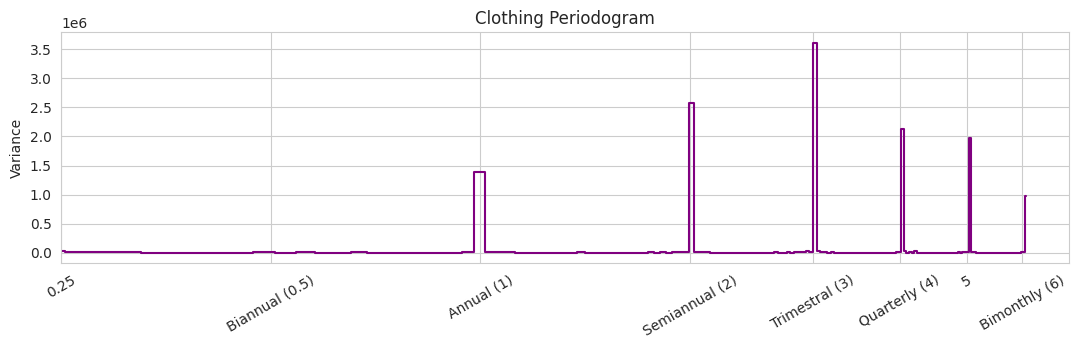

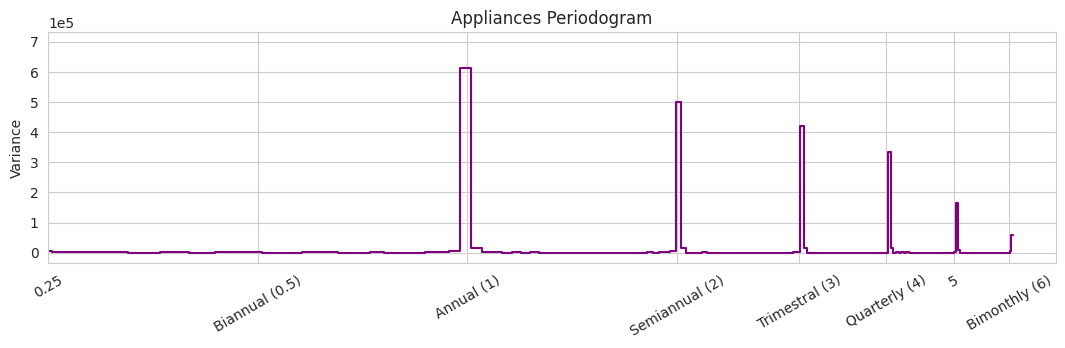

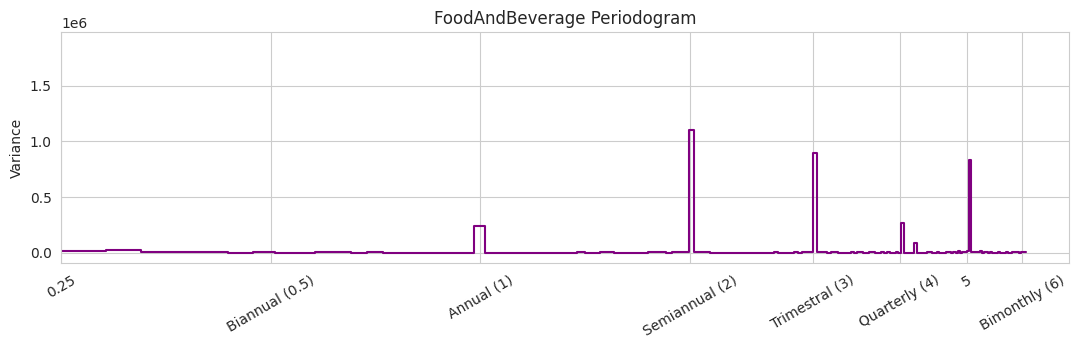

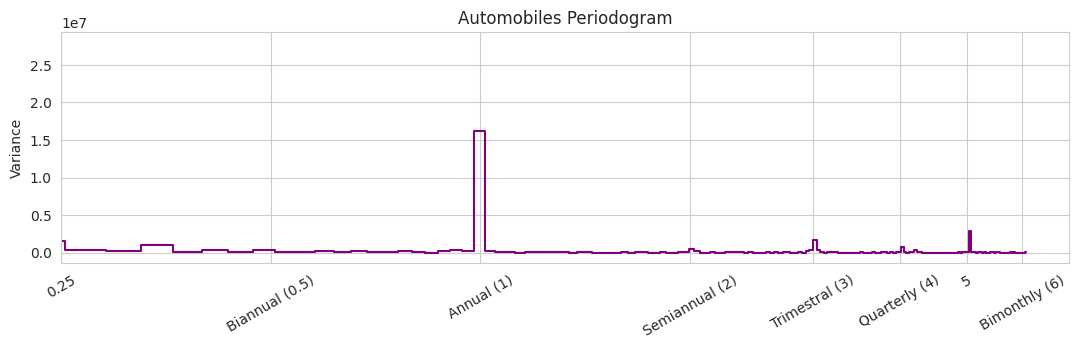

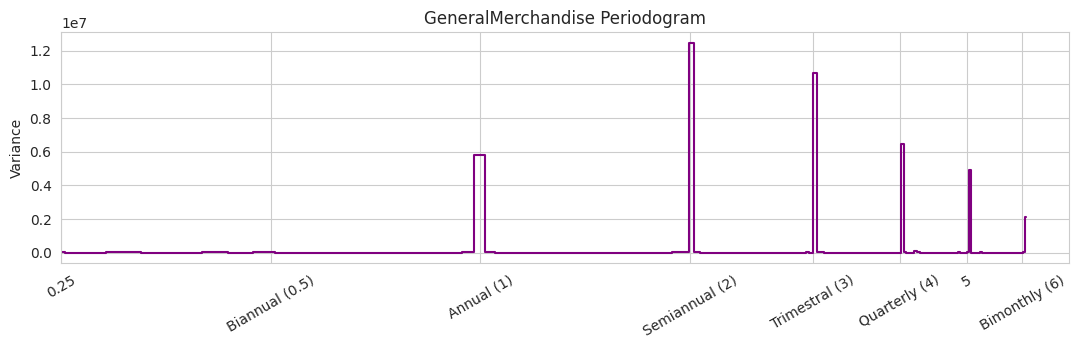

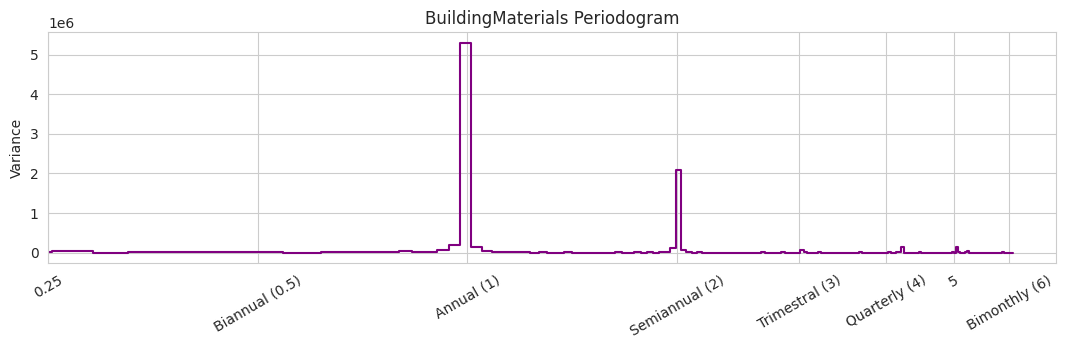

In [95]:
for i in categories:

    plot_periodogram(retail_sales[i], i);

#### Descomposición estacional

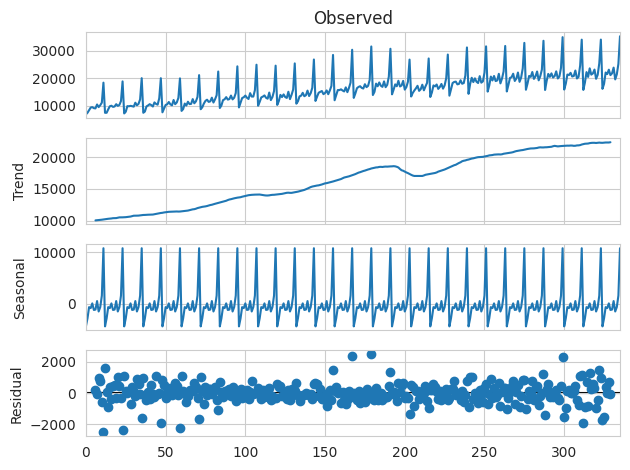

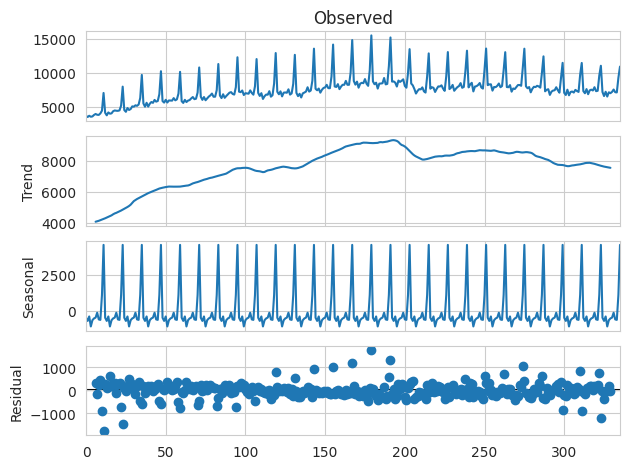

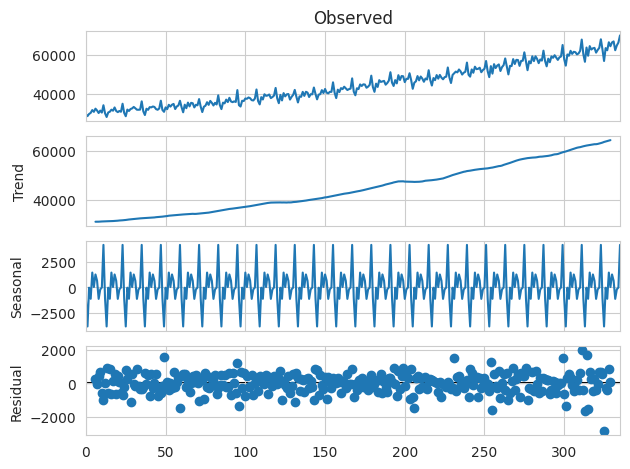

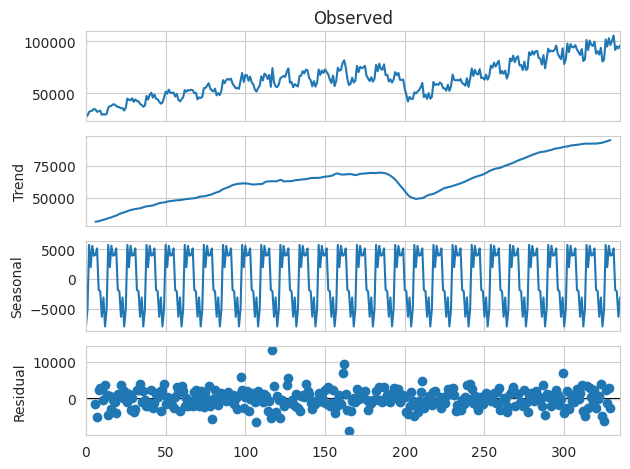

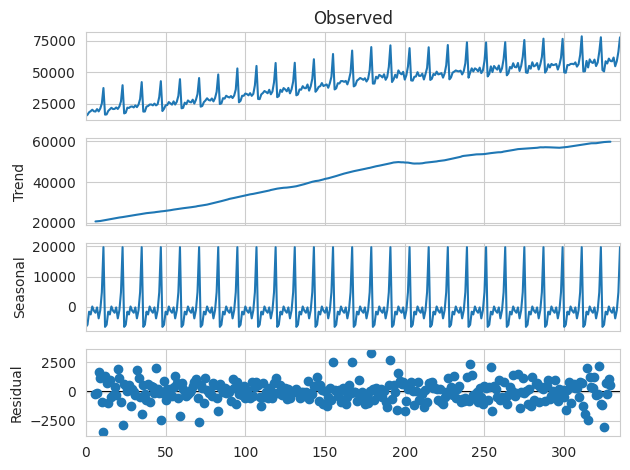

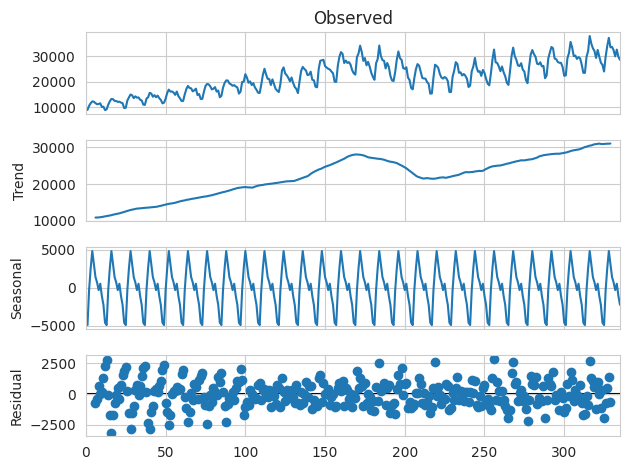

In [131]:
# Modelo aditivo

for i in categories:
    
    res = sm.tsa.seasonal_decompose(retail_sales[i].values,period=12,model="additive")
    fig = res.plot();

#### Test estadisticos de estacionalidad y ruido

In [159]:
import statsmodels.api as sm
from arch.unitroot import ADF, PhillipsPerron

for i in categories:
    
    bds_test = sm.tsa.stattools.bds(retail_sales[i]) # Se rechaza la hipotesis nula: La serie es iid (Característica del ruido)

    box_test = sm.stats.acorr_ljungbox(retail_sales[i], lags=[1], return_df=True) # Se rechaza la hipotesis Ho: La serie es ruido

    ljung_box_test = sm.stats.acorr_ljungbox(retail_sales[i], lags=[1], return_df=True)  # Se rechaza la hipotesis Ho: La serie es ruido

    adf_test = ADF(retail_sales[i]) # No se rechaza la Ho: La serie tiene raíz unitaria (no es estacionaria)

    pp_test = PhillipsPerron(retail_sales[i]) # No se rechaza la Ho: La serie tiene raíz unitaria (no es estacionaria)

    # Resultados
    print('-------------------')
    print('Tests for '+i)
    print("BDS Test:", bds_test)
    print("Box Test:", box_test)
    print("Ljung-Box Test:", ljung_box_test)
    print("ADF Test:", adf_test.summary().as_text())
    print("PP Test:", pp_test.summary().as_text())


-------------------
Tests for Clothing
BDS Test: (array(15.45016809), array(7.52469741e-54))
Box Test:      lb_stat     lb_pvalue
1  87.069896  1.047530e-20
Ljung-Box Test:      lb_stat     lb_pvalue
1  87.069896  1.047530e-20
ADF Test:    Augmented Dickey-Fuller Results   
Test Statistic                 -0.711
P-value                         0.844
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
PP Test:      Phillips-Perron Test (Z-tau)    
Test Statistic                -14.925
P-value                         0.000
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
----------------